# Is uv significantly faster than pip in Docker builds?

The purpose of this project is to find out if the recently released `uv` library is significantly faster than the `pip` dependency hanlder in building Docker images. The process of building a Docker image is very annoying during development, especially if done multiple times. The aim of this work is to set up a small test bench to see if switching to `uv` is worth it.

## Imports

In [17]:
import re
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

import matplotlib.pyplot as plt
import pandas as pd

### Read results

In [2]:
with open('../docker_build_times_pip.txt', 'r') as f:
    lines_pip = f.readlines()

with open('../docker_build_times_uv.txt', 'r') as f:
    lines_uv = f.readlines()

lines_pip = [int(re.search(r'(\d+)', line.strip()).group(0)) for line in lines_pip]
lines_uv = [int(re.search(r'(\d+)', line.strip()).group(0)) for line in lines_uv]

### Convert to df for cleanness

In [7]:
df = pd.DataFrame({'pip': lines_pip, 'uv': lines_uv})

# discard the first outlier value:
df = df.iloc[1:]

df.sample(2)

,pip,uv
13,125,49
1,106,40


# Results

I will explore the results in two ways. First, visually by plotting the data and intuitively checking if the values differ significantly, and then I will use some statistical tests to further confirm the findings. The first part will just visually explore the results, we will plot the distribution of the time the experiments took. We have >30 samples for each experiment, so we can leverage the Central Limit Theorem if we need to make a more robust test of the results.

### Plot results

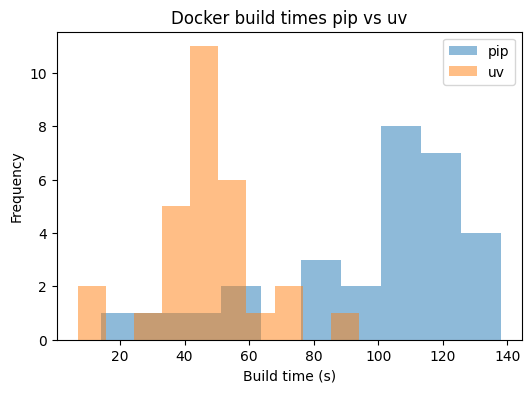

In [8]:
plt.figure(figsize=(6, 4))

plt.hist(df['pip'], alpha=0.5, label='pip')
plt.hist(df['uv'], alpha=0.5, label='uv')

plt.xlabel('Build time (s)')
plt.ylabel('Frequency')
plt.title('Docker build times pip vs uv')

plt.legend()

plt.savefig('images/hist_docker_build_times_pip_vs_uv.png');

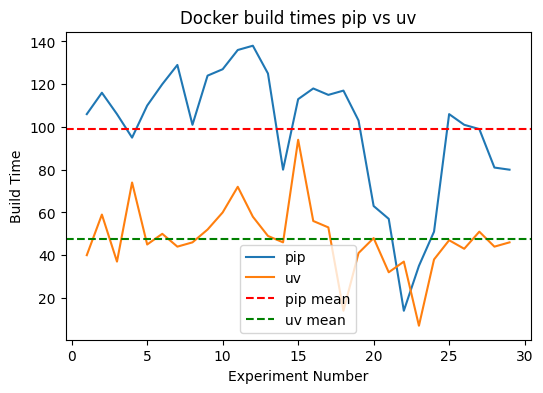

In [9]:
plt.figure(figsize=(6, 4))

plt.plot(df['pip'], label='pip')
plt.plot(df['uv'], label='uv')

plt.axhline(df["pip"].mean(), label='pip mean', color='r', linestyle='--')
plt.axhline(df["uv"].mean(), label='uv mean', color='g', linestyle='--')

plt.xlabel('Experiment Number')
plt.ylabel('Build Time')
plt.title('Docker build times pip vs uv')

plt.legend()

plt.savefig('images/docker_build_times_pip_vs_uv.png');

Both plots above show the difference very clearly. Even though we haven't used a statistical approach to quantify how certain we are about the difference, it's easy to see that there is a difference in the raw plots. We still have to discard that this is due to random chance using statistics, which we will do next.

The second plot shows the mean of the observations for each case. The more observations we have, the more robust this method will be in determining the difference in build times using pip versus the new "uv" library.

## Statistical Analysis

In order to make a more robust statement about the observations, we need statistics ❤️. A suitable approach in this case would be to test for the means of the two populations this samples were drawn from. We don't know the nature of the population mean, nor it's variance so we will use a two sample t-test and build a hypothesis test to check if $\mu_1 < \mu_2$, where $\mu_1$ is the mean of the docker build time using the `uv` library, while $\mu_2$ is the docker build time using the traditional `pip install` method.

We will formulate the following test: 
- **H0) Null Hypothesis:** The mean of the pip build time is smaller or equal than the mean of the uv build time on average.

- **H1) Alternate Hypothesis:** The mean of the uv build time is on average smaller than the pip build time.

We will use a t-test to test the hypothesis stated. We will use scipy's Shapiro-Wilk's test to check for normality, as the test assumes both distributions are normally distributed. We will also use Levene's test to test for the variance of the two populations being equal. Both turn out to be wrong.

In [10]:
pip_results = df["pip"].values
uv_results = df["uv"].values

shapiro_pip = shapiro(pip_results)
shapiro_uv = shapiro(uv_results)

levene_test = levene(pip_results, uv_results)

shapiro_pip, shapiro_uv, levene_test

(ShapiroResult(statistic=0.8935694098472595, pvalue=0.006896034348756075),
 ShapiroResult(statistic=0.9229437112808228, pvalue=0.036226823925971985),
 LeveneResult(statistic=5.476973823317969, pvalue=0.022857089337592087))

Above we can see that for a significance threshold of 5%, both p-values for normality and variance are lower than the threshold. This means that observing the results given the null hypothesis is rare, which means discarding the null hypotheses. In the Shapiro-Wilk test we reject that the data are normally distributed, while with the Levene's test we reject that the two samples have equal variance.

This means we will have to use a non-parametric test to check if the two distributions are different. In this case, we will use the Mann Whitney U test, which is a non-parametric test for testing that the underlying distribution of the build times for the uv sample are the same as the pip sample.

In [18]:
mannwhitneyu_result = mannwhitneyu(uv_results, pip_results, alternative='less')

mannwhitneyu_result

MannwhitneyuResult(statistic=75.0, pvalue=4.017227995635124e-08)

In [20]:
df["pip"].mean(), df["uv"].mean(), df["pip"].mean() / df["uv"].mean()

(98.82758620689656, 47.689655172413794, 2.072306579898771)

Given a significance threshold of 5%, we can safely reject the null hypothesis that the two samples where drawn from the same distribution, which is also evident in the data we have gathered and checked visually. 

### Conclusions:

- The analysis strongly suggests that the new process (uv_results) has a significantly lower mean execution time compared to the original process (pip_results), supporting the visual evidence provided by the distribution plots.

- Despite the original process's distribution deviating from normality, the large sample size (n=20 for each group) and the robustness of the t-test provide confidence in these findings.

- The extremely low p-value in the t-test underlines the statistical significance of the result, allowing us to conclude with high confidence that the new process is indeed faster.

- Despite all this, the difference in build times is, on average, 50% in the tests. Which means that you could reduce your builds by half on average. This is good, but in my opinion it doesn't grant switching. Of course this depends on the number of libraries. I can imagine that for very memory-intensive dependencies, this will be worth it.